In [211]:
import numpy as np
#from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"

num_runs = 10
iter_list = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
glimpse_list = [0,3,9]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
output_size = max_blobs - min_blobs + 1
chist = np.load(data_directory + 'choice_hist.npy')[:,:,:,:10,:10]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:,:10,:10]

cmus = cm[:,:,:,:,0] # mean
csds = cm[:,:,:,:,1] # sd
ccvs = cm[:,:,:,:,2] # cv

In [212]:
# take the averages across the 10 runs
chist_mu = np.mean(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [213]:
def plot_hists(matrix,i_ind):
    fig, ax = plt.subplots(12,num_glimpses,sharex=True, sharey=True,figsize=(8,16))
    x = range(1, 10)
    fig.tight_layout()
    plt.xticks(range(1, 10))
    for c in range(num_glimpses):
        for i in range(12):
            tstr = 'I = ' + str(iter_list[i]) + ', G = ' + str(glimpse_list[c])
            ax[i][c].set_title(tstr)
            ax[i][c].plot(x,matrix[i,c,:9])
    plt.show()

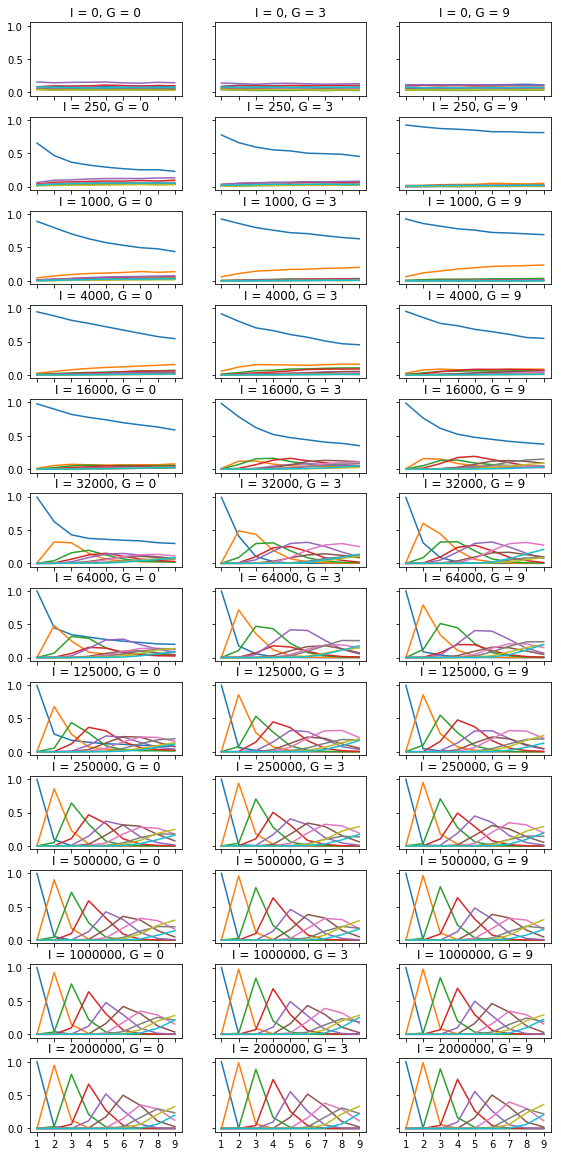

In [214]:
iter_idx = num_iters - 1
plot_hists(chist_mu,iter_idx)

## Run Linear Regression

In [239]:
import scipy.stats as st

def get_linreg(cvals,num_runs=10,eouts=range(1,10)):
    """Get lines of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    intercepts = np.zeros(num_runs)
    r_vals = np.zeros(num_runs)
    
    if num_runs is 1:
        aouts = np.array([cvals[eout-min_blobs] for eout in eouts])
        slopes, intercepts, r_vals, _, _ = st.linregress(eouts, aouts)
    else:
        for run in range(num_runs):
            aouts = np.array([cvals[run,eout-min_blobs] for eout in eouts])
            slopes[run], intercepts[run], r_vals[run], _, _ = st.linregress(eouts, aouts)
    
    return slopes, intercepts, r_vals

(10, 12, 3, 10)


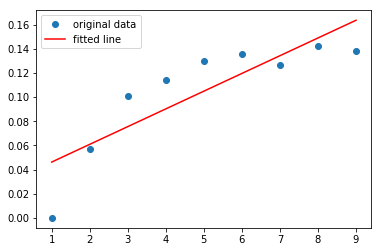

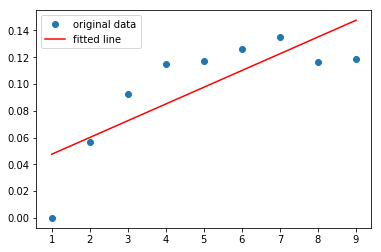

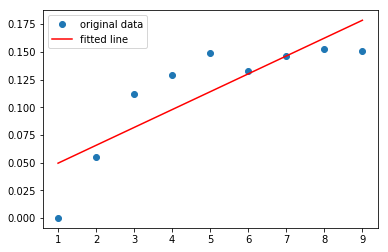

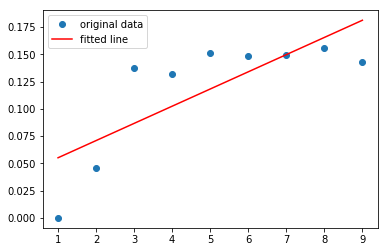

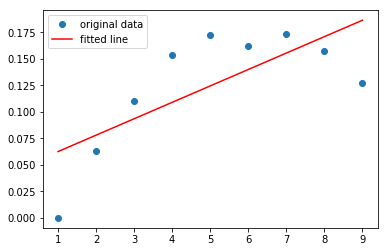

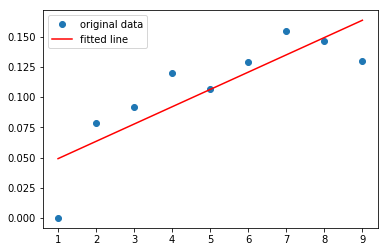

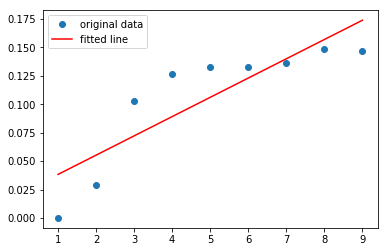

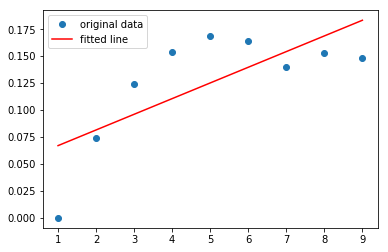

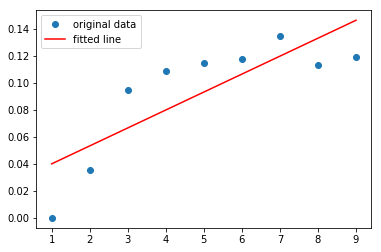

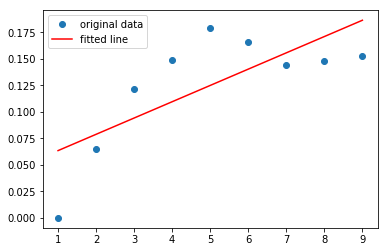

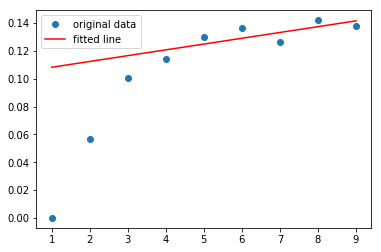

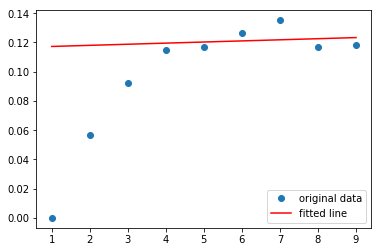

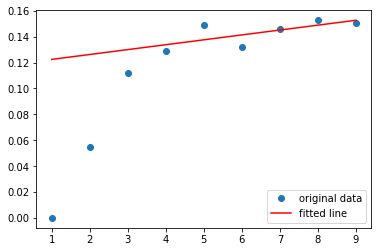

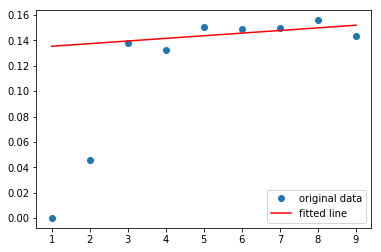

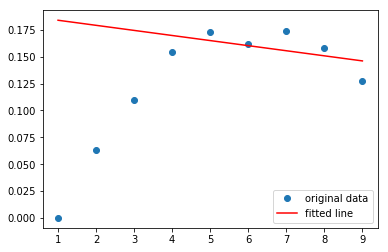

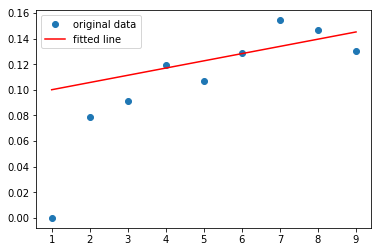

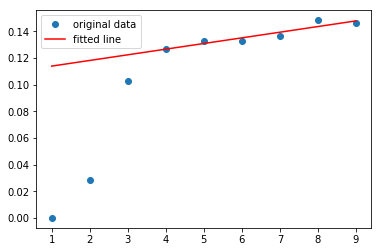

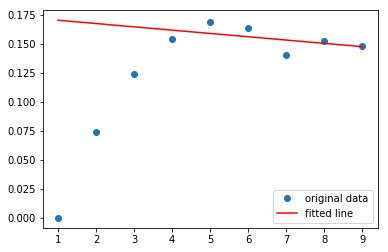

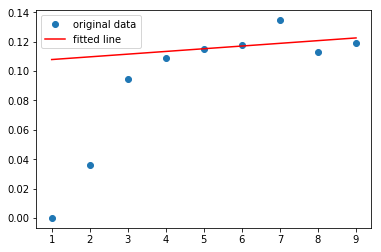

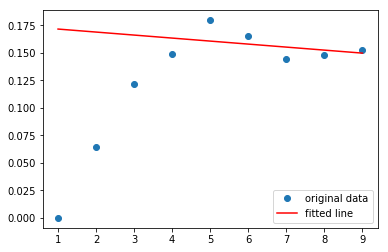

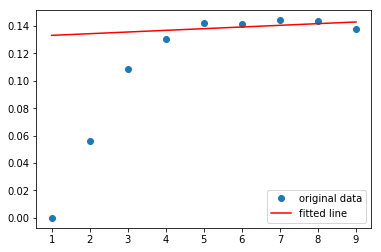

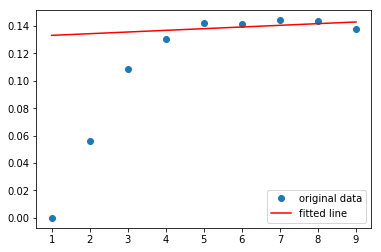

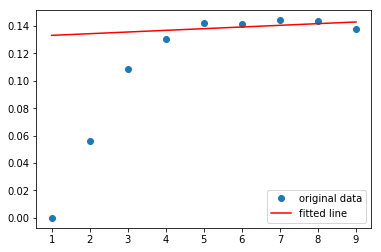

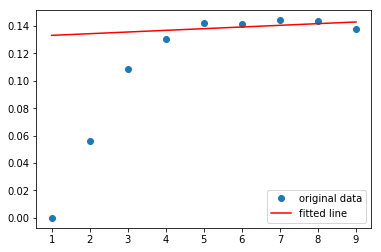

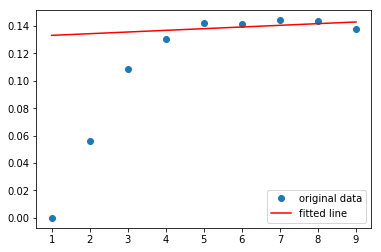

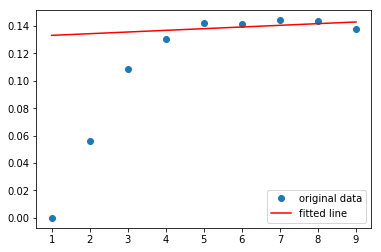

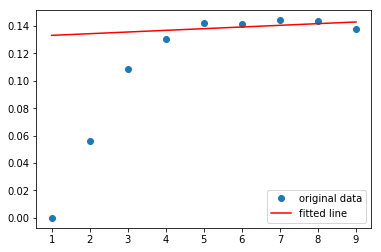

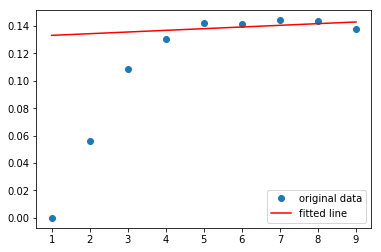

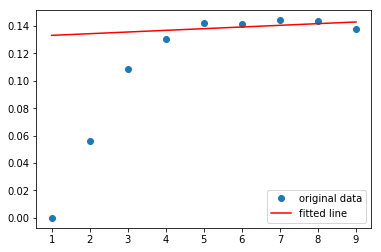

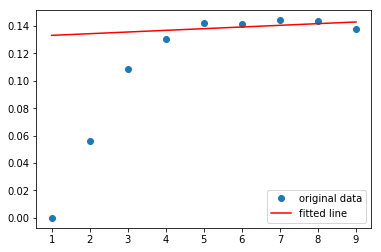

In [241]:
print(cmus.shape)

cmus_slopes, cmus_intercepts, cmus_rvals = get_linreg(cmus[:,11,2])
csds_slopes, csds_intercepts, csds_rvals = get_linreg(csds[:,11,2])
ccvs_slopes, ccvs_intercepts, ccvs_rvals = get_linreg(ccvs[:,11,2])
ccvs_slopes_4to9, ccvs_intercepts_4to9, ccvs_rvals_4to9 = get_linreg(ccvs[:,11,2],eouts=range(4,10))
ccvs_slopes_4to9_mu, ccvs_intercepts_4to9_mu, ccvs_rvals_4to9_mu = get_linreg(ccvs_mu[11,2],num_runs=1,eouts=range(4,10))


# Visualize

# for i in range(num_runs):
#     plt.plot(range(1,10), cmus[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), cmus_intercepts[i] + cmus_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()

# for i in range(num_runs):
#     plt.plot(range(1,10), csds[i,:9], 'o', label='original data')
#     plt.plot(range(1,10), csds_intercepts[i] + csds_slopes[i]*range(1,10), 'r', label='fitted line')
#     plt.legend()
#     plt.show()
    
for i in range(num_runs):
    plt.plot(range(1,10), ccvs[i,11,2,:9], 'o', label='original data')
    plt.plot(range(1,10), ccvs_intercepts[i] + ccvs_slopes[i]*range(1,10), 'r', label='fitted line')
    plt.legend()
    plt.show()

for i in range(num_runs):
    plt.plot(range(1,10), ccvs[i,11,2,:9], 'o', label='original data')
    plt.plot(range(1,10), ccvs_intercepts_4to9[i] + ccvs_slopes_4to9[i]*range(1,10), 'r', label='fitted line')
    plt.legend()
    plt.show()
    
for i in range(num_runs):
    plt.plot(range(1,10), ccvs_mu[11,2,:9], 'o', label='original data')
    plt.plot(range(1,10), ccvs_intercepts_4to9_mu + ccvs_slopes_4to9_mu*range(1,10), 'r', label='fitted line')
    plt.legend()
    plt.show()

In [183]:
import math

def get_CI(vals):
    """Get the 95% confidence intervals."""

    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(9)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 3), round(hw, 3)

# Confidence Intervals

## Mean Choice

### Slope

In [8]:
get_CI(cmus_slopes)

(0.97999999999999998, 0.02)

### Intercept

In [9]:
get_CI(cmus_intercepts)

(0.02, 0.040000000000000001)

### R-Values

In [10]:
get_CI(cmus_rvals)

(1.0, 0.0)

## Standard Deviation of Choice

### Slope

In [11]:
get_CI(csds_slopes)

(0.16, 0.01)

### Intercept

In [12]:
get_CI(csds_intercepts)

(-0.14999999999999999, 0.02)

### R-Values

In [13]:
get_CI(csds_rvals)

(0.98999999999999999, 0.01)

## Coefficient of Variation of Choice

### Slope

In [14]:
get_CI(ccvs_slopes)

(0.01, 0.0)

### Intercept

In [15]:
get_CI(ccvs_intercepts)

(0.040000000000000001, 0.01)

### R-Values

In [16]:
get_CI(ccvs_rvals)

(0.79000000000000004, 0.029999999999999999)

# Final DRAM Chart

In [135]:
x = range(0,10)

def plot_graph(tstr, ax, col, ylim, cvals):
    """Plot a single graph."""

    # take the averages across the 10 runs
    smu = np.mean(cvals,axis=0)
    smin = np.min(cvals,axis=0)
    smax = np.max(cvals,axis=0)

    ax.set_title(ax.get_title() + tstr)
    ax.set_ylim(bottom=0,top=ylim)
    ax.set_xlim(left=0,right=9)
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_ticks_position('left')
    
    smu = np.insert(smu,0,None)
    ax.plot(x, smu[:10],'k-')

#     ax.set_xlabel("Stimulus Numerosity")

    slopes, intercepts, rvals = get_linreg(cvals)
    S_mean, S_hw = get_CI(slopes)
    I_mean, I_hw = get_CI(intercepts)
    R_mean, R_hw = get_CI(rvals)

    ax.text(.25, .75, '$S: ' + str(S_mean) + ' \pm ' + str(S_hw) + \
            '$ \n $I: ' + str(I_mean) + ' \pm ' + str(I_hw) + \
            '$ \n $R: ' + str(R_mean) + ' \pm ' + str(R_hw) + '$',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

    smin = np.insert(smin,0,None)
    smax = np.insert(smax,0,None)
    ax.fill_between(x,smin[:10],smax[:10], facecolor='orange')
    
    
def plot_stats(cmus, csds, ccvs, all_iters, iter_indices, title=None):
    """Make the table of graphs."""
    
    size = 4
    fig, ax = plt.subplots(len(iter_indices),3,sharex=True, sharey=True,figsize=(size*3,size*len(iter_indices)))
    plt.xticks(range(0,10))
    plt.xlabel("Stimulus Numerosity")
    ax[0,0].set_title("$\mathbf{Mean\ Choice}$\n\n")
    ax[0,1].set_title("$\mathbf{Standard\ Deviation}$\n\n")
    ax[0,2].set_title("$\mathbf{Coefficient\ of\ Variation}$\n\n")

        
    for i, iter_idx in enumerate(iter_indices):        
        plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][0], 0, 10, cmus[:,iter_idx])
        plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][1].twinx(), 1, 3, csds[:,iter_idx])
        plot_graph("Iteration: " + str(all_iters[iter_idx]), ax[i][2].twinx(), 2, .5, ccvs[:,iter_idx])
        
    fig.tight_layout()
    
    if title is not None:
        fig.suptitle(title, fontsize=16)
        fig.subplots_adjust(top=.95)

    plt.show()

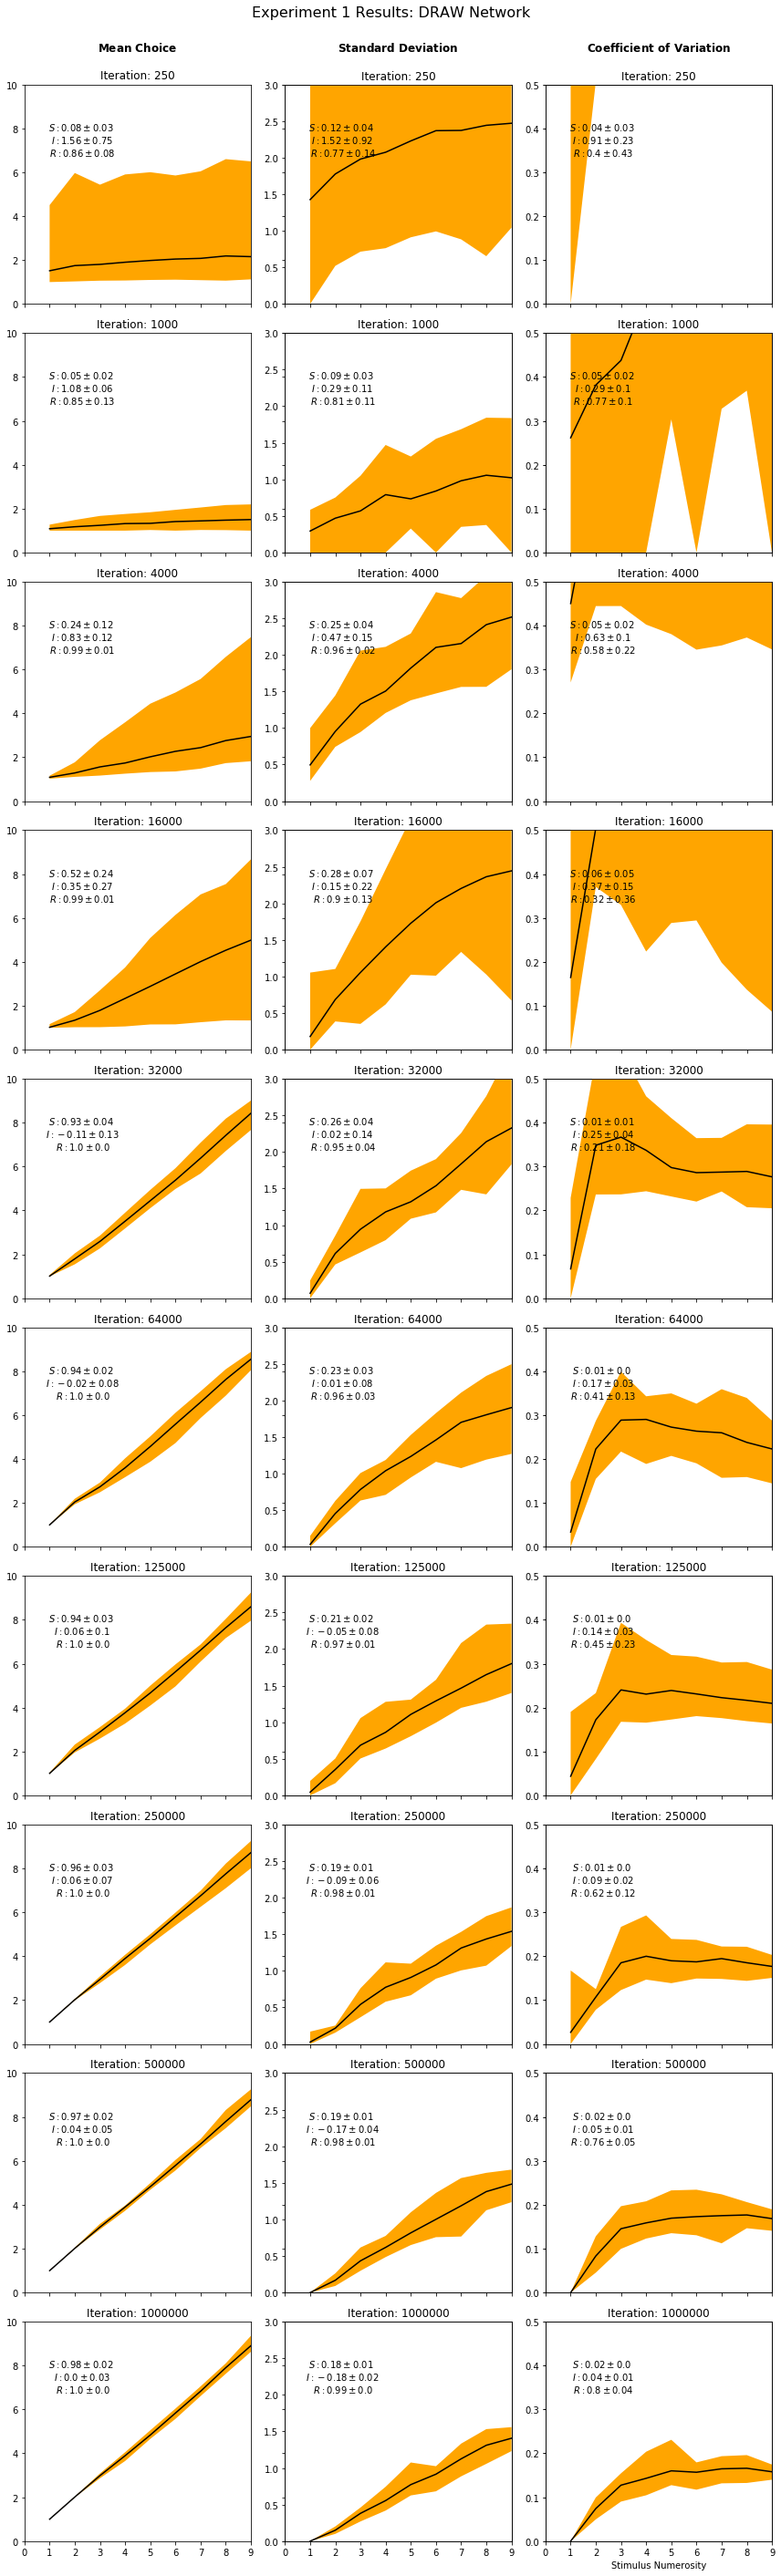

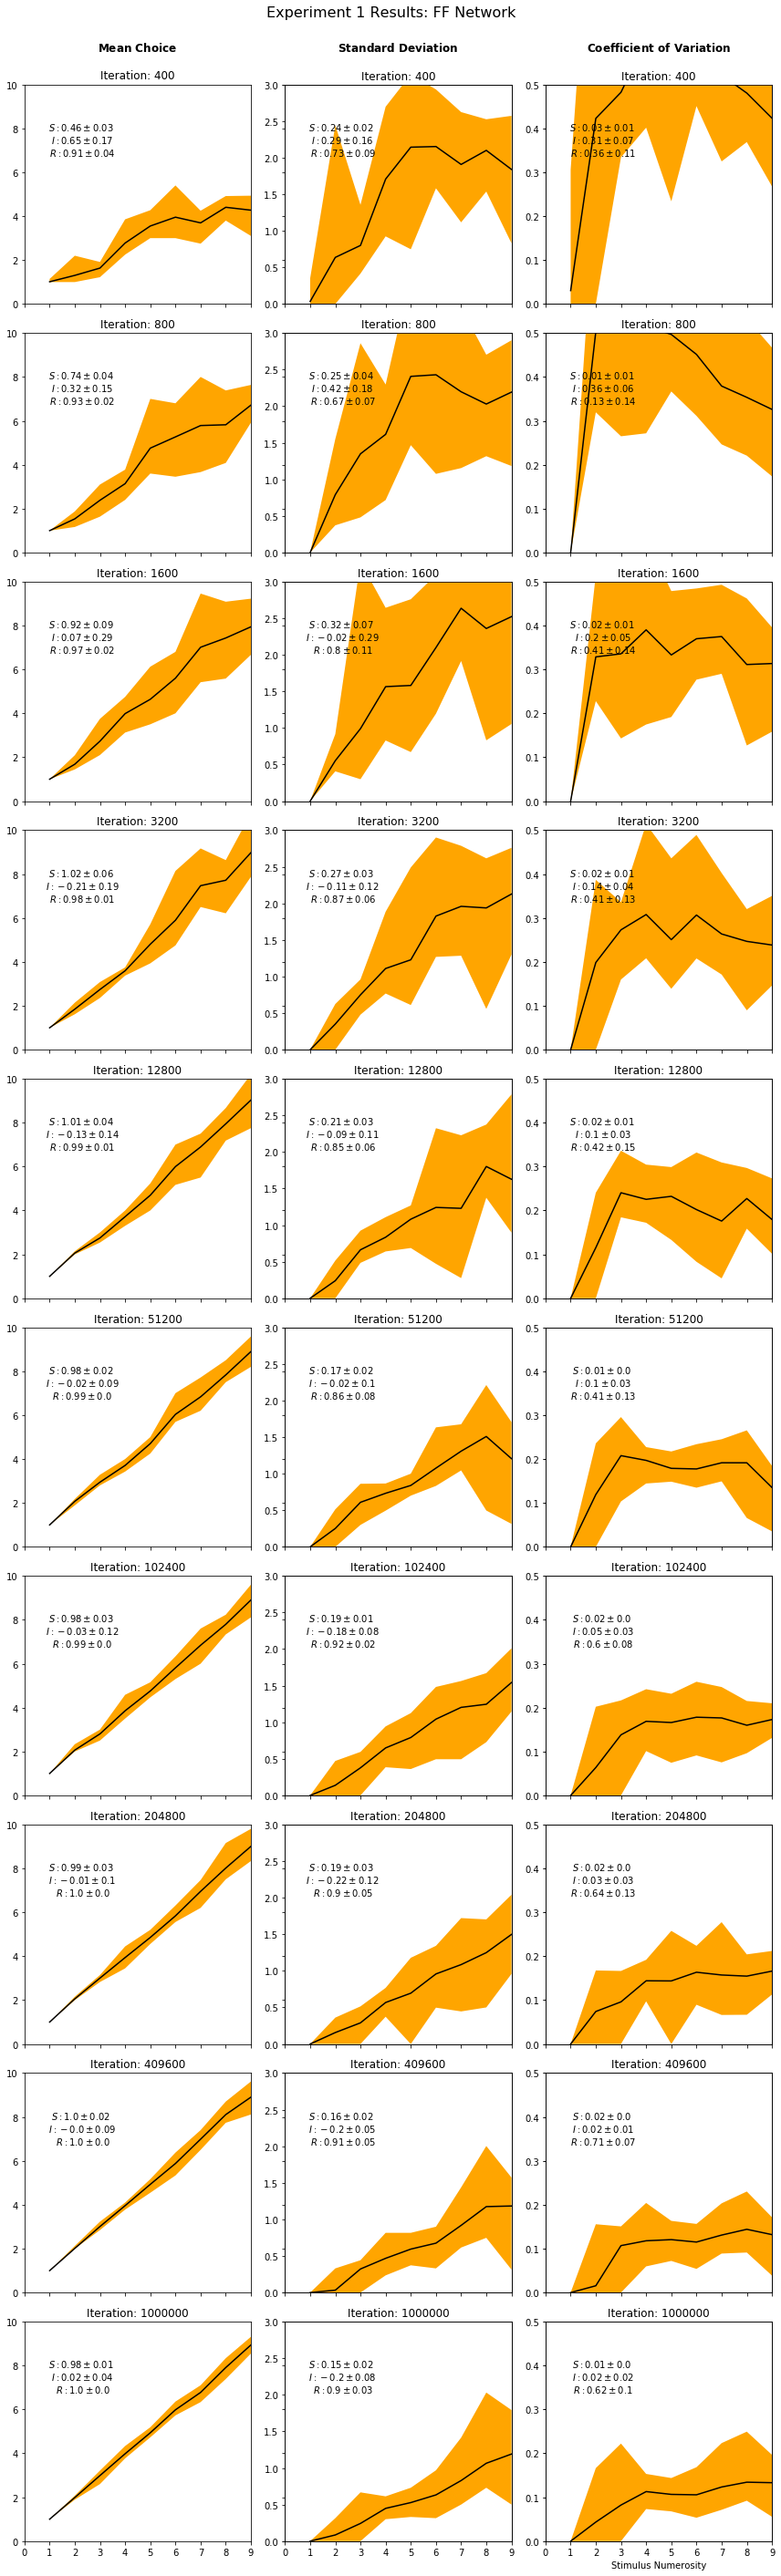

In [136]:
model_name = "DRAM_classify_blobs_2"
data_directory = "data/" + model_name + "/"
all_iters = [0, 250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000, 2000000]
iters = [250, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,2,:10,:10]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: DRAW Network")

model_name = "DRAM_onelayer"
data_directory = "data/" + model_name + "/"
all_iters = [0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 1228800, 1638400, 2000000, 2457600, 3000000]
iters = [400, 800, 1600, 3200, 12800, 51200, 102400, 204800, 409600, 1000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
cm = np.load(data_directory + 'choice_msdcv.npy')[:,:,:10,:10]
cmus = cm[:,:,:,0] # mean
csds = cm[:,:,:,1] # sd
ccvs = cm[:,:,:,2] # cv
plot_stats(cmus, csds, ccvs, all_iters, iter_indices, "Experiment 1 Results: FF Network")

In [102]:
a[c[0]:c[-1]]

[1, 2, 3, 4, 6, 8, 9, 11, 13, 16]